Overall Summary Statistics:
       Malnutrition_Death_Rate  Health_Expenditure_GDP  GDP_per_capita
count               183.000000              183.000000      183.000000
mean                  2.945824                7.345628    24472.410475
std                   4.062311                3.299522    25447.086989
min                   0.000000                2.200000      836.665600
25%                   0.220000                4.960000     5996.532800
50%                   1.570000                6.970000    15663.175000
75%                   3.875000                9.370000    36259.506500
max                  23.410000               21.830000   137947.340000

Summary for Low-GDP:
       Malnutrition_Death_Rate  Health_Expenditure_GDP
count                61.000000               61.000000
mean                  5.970164                6.458689
std                   5.445566                4.103801
min                   0.040000                2.320000
25%                   1.940000      

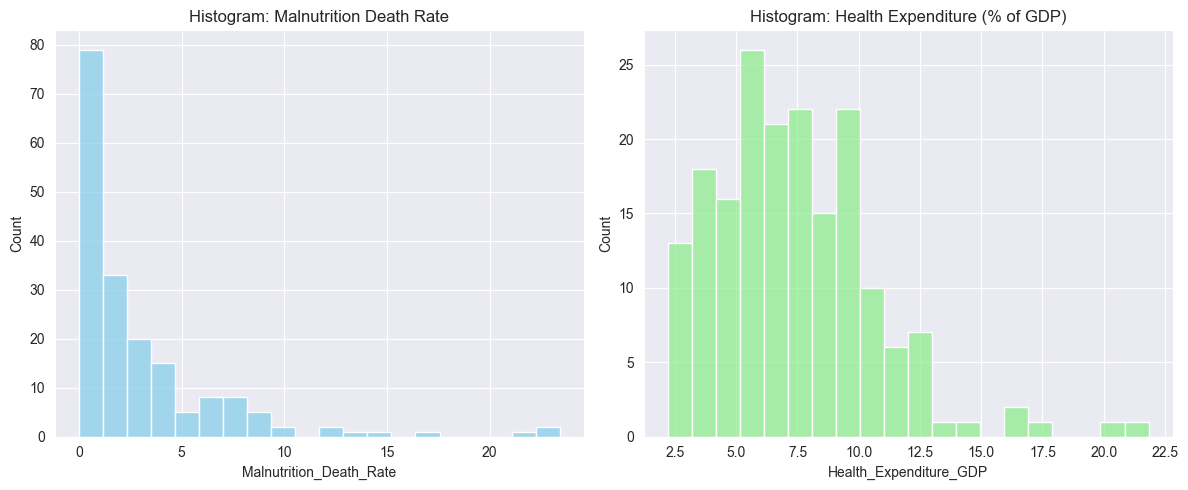

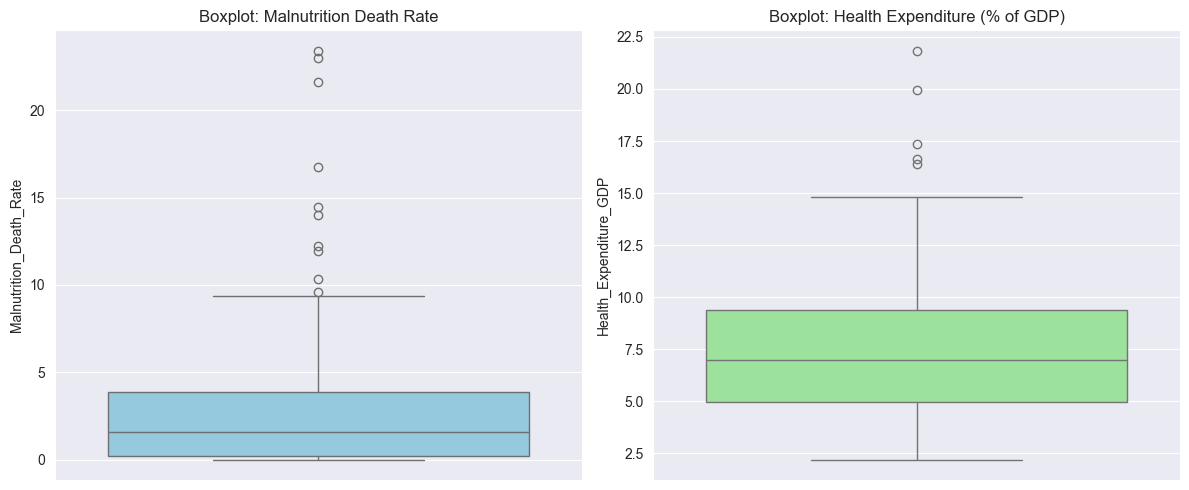

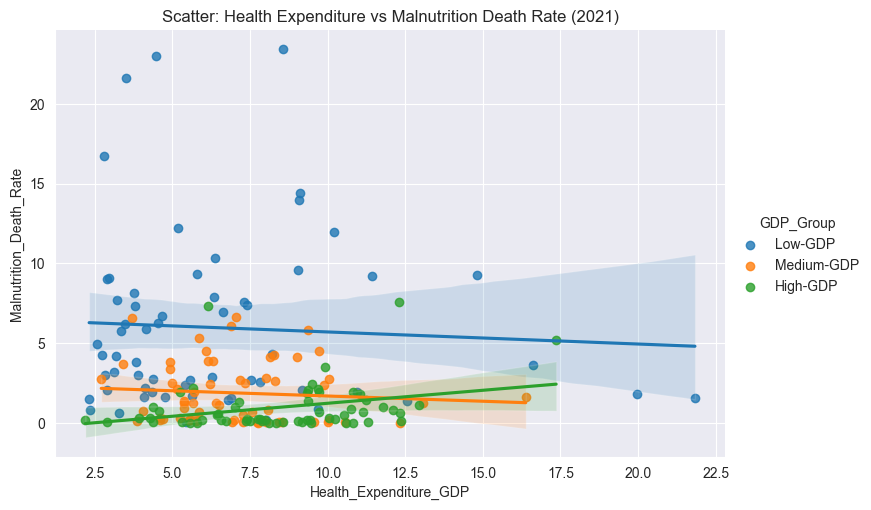


                        Low-GDP  Medium-GDP High-GDP
----------------------------------------------------
Intercept              6.4591*** 2.3452***  -0.3950 
                       (1.1406)  (0.6478)   (0.6751)
Health_Expenditure_GDP -0.0757   -0.0657    0.1628**
                       (0.1316)  (0.0815)   (0.0829)
R-squared              0.0033    0.0071     0.0884  
R-squared Adj.         -0.0136   -0.0097    0.0729  
N                      61        61         61      
R2                     0.00      0.01       0.09    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01

ECONOMIC INTERPRETATION:

Low-GDP Group:
  - A 1 unit increase in Health_Expenditure_GDP is associated with a 0.08 unit decrease in malnutrition death rate. This effect is not significant (p = 0.5651).
  - R² = 0.003: This means that 0.3% of the variation in malnutrition death rate is explained by health expenditure in this GDP group.
  ➤ Economically, this suggests that healthcare spending is not signific

In [5]:
# Programming Final Project: Analyzing the Relationship between Health Expenditure and Malnutrition Death Rate
# By: Elena Comellas

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.iolib.summary2 import summary_col


def load_and_merge_data(death_path: str, health_path: str, gdp_path: str) -> pd.DataFrame:
    """
    Loads and merges death rate, healthcare expenditure, and GDP datasets.

    Args:
        death_path (str): File path for malnutrition death rate dataset.
        health_path (str): File path for health expenditure dataset.
        gdp_path (str): File path for GDP per capita dataset.

    Returns:
        pd.DataFrame: Cleaned and merged dataset for the year 2021.
    """
    death = pd.read_csv(death_path)[['Entity', 'Year', 'Death rate from protein-energy malnutrition among both sexes']]
    death.columns = ['Country', 'Year', 'Malnutrition_Death_Rate']

    health = pd.read_csv(health_path)[[
        'Entity', 'Year', 'Current health expenditure (CHE) as percentage of gross domestic product (GDP) (%)']]
    health.columns = ['Country', 'Year', 'Health_Expenditure_GDP']

    gdp = pd.read_csv(gdp_path)[['Entity', 'Year', 'GDP per capita, PPP (constant 2021 international $)']]
    gdp.columns = ['Country', 'Year', 'GDP_per_capita']

    merged = pd.merge(pd.merge(death, health, on=['Country', 'Year']), gdp, on=['Country', 'Year'])
    return merged[merged['Year'] == 2021].dropna()


def assign_gdp_groups(df: pd.DataFrame) -> pd.DataFrame:
    """
    Assigns GDP per capita tertile groups to countries.

    Args:
        df (pd.DataFrame): Merged dataset.

    Returns:
        pd.DataFrame: Dataset with new GDP group column.
    """
    df['GDP_Group'] = pd.qcut(df['GDP_per_capita'], 3, labels=['Low-GDP', 'Medium-GDP', 'High-GDP'])
    return df


def summarize_statistics(df: pd.DataFrame) -> None:
    """
    Prints summary statistics overall and by GDP group.

    Args:
        df (pd.DataFrame): Dataset with GDP group labels.
    """
    print("Overall Summary Statistics:")
    print(df[['Malnutrition_Death_Rate', 'Health_Expenditure_GDP', 'GDP_per_capita']].describe())

    for group in df['GDP_Group'].unique():
        print(f"\nSummary for {group}:")
        print(df[df['GDP_Group'] == group][['Malnutrition_Death_Rate', 'Health_Expenditure_GDP']].describe())


def plot_distributions(df: pd.DataFrame) -> None:
    """
    Plots histograms and boxplots of variables.

    Args:
        df (pd.DataFrame): Dataset to visualize.
    """
    # Histograms
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df['Malnutrition_Death_Rate'], bins=20, color='skyblue')
    plt.title("Histogram: Malnutrition Death Rate")

    plt.subplot(1, 2, 2)
    sns.histplot(df['Health_Expenditure_GDP'], bins=20, color='lightgreen')
    plt.title("Histogram: Health Expenditure (% of GDP)")
    plt.tight_layout()
    plt.show()

    # Boxplots
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.boxplot(y=df['Malnutrition_Death_Rate'], color='skyblue')
    plt.title("Boxplot: Malnutrition Death Rate")

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df['Health_Expenditure_GDP'], color='lightgreen')
    plt.title("Boxplot: Health Expenditure (% of GDP)")
    plt.tight_layout()
    plt.show()


def plot_scatter(df: pd.DataFrame) -> None:
    """
    Plots a scatterplot with regression lines by GDP group.

    Args:
        df (pd.DataFrame): Dataset with GDP groups.
    """
    sns.lmplot(data=df, x='Health_Expenditure_GDP', y='Malnutrition_Death_Rate',
               hue='GDP_Group', height=5, aspect=1.5)
    plt.title('Scatter: Health Expenditure vs Malnutrition Death Rate (2021)')
    plt.show()


def run_regressions(df: pd.DataFrame) -> dict:
    """
    Runs OLS regressions by GDP group.

    Args:
        df (pd.DataFrame): Dataset with GDP groups.

    Returns:
        dict: Dictionary of regression models per GDP group.
    """
    results = {}
    for group in df['GDP_Group'].unique():
        subset = df[df['GDP_Group'] == group]
        model = smf.ols('Malnutrition_Death_Rate ~ Health_Expenditure_GDP', data=subset).fit(cov_type='HC0')
        results[group] = model
    return results


def interpret_results(results: dict) -> None:
    """
    Prints a regression summary table and interprets economic meaning of results.

    Args:
        results (dict): Dictionary of fitted regression models.
    """
    summary = summary_col([results[g] for g in results],
                          stars=True,
                          model_names=list(results.keys()),
                          info_dict={'N': lambda x: f"{int(x.nobs)}",
                                     'R2': lambda x: f"{x.rsquared:.2f}"})
    print(summary)

    print("\nECONOMIC INTERPRETATION:")
    for group, model in results.items():
        print(f"\n{group} Group:")
        for var, coef in model.params.items():
            pval = model.pvalues[var]
            sig = "significant" if pval < 0.05 else "not significant"
            direction = "decrease" if coef < 0 else "increase"

            if var != "Intercept":
                print(f"  - A 1 unit increase in {var} is associated with a {abs(coef):.2f} unit {direction} "
                      f"in malnutrition death rate. This effect is {sig} (p = {pval:.4f}).")

        r2 = model.rsquared
        print(f"  - R² = {r2:.3f}: This means that {r2*100:.1f}% of the variation in malnutrition death rate "
              f"is explained by health expenditure in this GDP group.")

        # Economic intuition
        if model.pvalues["Health_Expenditure_GDP"] < 0.05:
            print("  ➤ Economically, this supports the idea that greater investment in health (as % of GDP) "
                  "is associated with fewer deaths from malnutrition in this income tier.")
        else:
            print("  ➤ Economically, this suggests that healthcare spending is not significantly linked to malnutrition "
                  "outcomes in this group — possibly due to inefficiencies or other stronger determinants.")


def breusch_pagan_tests(results: dict) -> None:
    """
    Performs Breusch-Pagan test for heteroskedasticity and provides interpretation.

    Args:
        results (dict): Dictionary of regression models.
    """
    print("\n📊 Breusch-Pagan Test Results and Interpretation:")
    for group, model in results.items():
        bp = het_breuschpagan(model.resid, model.model.exog)
        labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
        print(f"\n{group} Group:")
        for label, stat in zip(labels, bp):
            print(f"{label}: {stat:.4f}")

        pval = bp[1]  # LM-Test p-value
        if pval < 0.05:
            print("  ➤ Interpretation: There is significant evidence of heteroskedasticity in this group (p < 0.05).")
            print("    → Economically, this suggests that the variability of malnutrition deaths may depend on levels of healthcare expenditure.\n"
                  "    → The model's error variance is not constant, which might bias standard errors — robust methods are recommended.")
        else:
            print("  ➤ Interpretation: No significant evidence of heteroskedasticity (p ≥ 0.05).")
            print("    → Economically, this means the residual variation in malnutrition deaths is relatively stable across levels of healthcare spending.")



def main() -> None:
    """
    Main execution pipeline for the analysis.
    """
    df = load_and_merge_data(
        "data/death-rate-from-malnutrition-ghe.csv",
        "data/total-healthcare-expenditure-gdp.csv",
        "data/gdp-per-capita-worldbank.csv"
    )
    df = assign_gdp_groups(df)

    summarize_statistics(df)
    plot_distributions(df)
    plot_scatter(df)

    results = run_regressions(df)
    interpret_results(results)
    breusch_pagan_tests(results)


if __name__ == "__main__":
    main()
